In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_final_speed(
    desire_direction: np.ndarray,
    ocean_current_velocity: np.ndarray,
    applied_vehicle_speed: float,
):
    assert np.isclose(np.linalg.norm(desire_direction), 1)

    # the projected ocean current that aligns with our desire direction (can be negative)
    current_mag_in_desire_dir = np.dot(ocean_current_velocity, desire_direction)

    # the ocean current magnitude that was NOT in the desire (i.e. the side-way component)
    current_mag_needed_to_counteract = np.sqrt(
        np.linalg.norm(ocean_current_velocity) ** 2
        - np.abs(current_mag_in_desire_dir) ** 2
    )

    assert (
        applied_vehicle_speed > current_mag_needed_to_counteract
    ), "ocean current is bigger than what we can handle"

    # the amount of vehicle velocity magnitude available after accounting for
    # the side-way component (i.e. perpendicular component) of ocean current
    vehicle_vel_mag_available = np.sqrt(
        applied_vehicle_speed**2 - current_mag_needed_to_counteract**2
    )

    final_speed_in_desire_direction = (
        vehicle_vel_mag_available + current_mag_in_desire_dir
    )

    return final_speed_in_desire_direction


def get_velocity_to_apply(
    desire_direction: np.ndarray,
    ocean_current_velocity: np.ndarray,
    applied_vehicle_speed: float,
):
    vel_inline = np.dot(desire_direction, ocean_current_velocity) * desire_direction
    perpend_vel_to_negate = -(ocean_current_velocity - vel_inline)
    applied_velocity_vector = perpend_vel_to_negate + desire_direction * np.sqrt(
        applied_vehicle_speed**2 - np.linalg.norm(perpend_vel_to_negate) ** 2
    )
    return applied_velocity_vector


applied_speed = 2
# applied_speed = np.random.rand()*5 + 2

_dir = np.array([-0.9, 11.2, 3])
# _dir = np.random.rand(3) * 4 - 2
desire_direction_unit_vec = _dir / np.linalg.norm(_dir)

# ocean current
ocean_current = np.array([-1.1, -0.113, 0])
# ocean_cur = np.random.rand(3) * 3


applied_speed = compute_final_speed(
    desire_direction_unit_vec,
    ocean_current,
    applied_speed,
)
applied_velocity = get_velocity_to_apply(
    desire_direction_unit_vec,
    ocean_current,
    applied_speed,
)

result_velocity = ocean_current + applied_velocity

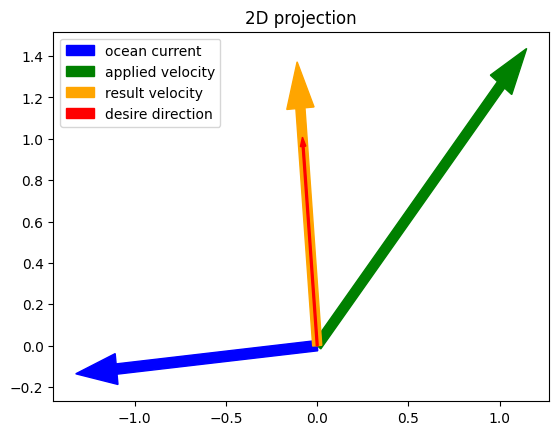

In [3]:
def draw_arrow(vector, origin=(0, 0), **kwargs):
    plt.arrow(
        origin[0], origin[1], origin[0] + vector[0], origin[1] + vector[1], **kwargs
    )


draw_arrow(
    ocean_current,
    width=0.05,
    color="blue",
    label="ocean current",
)
draw_arrow(
    applied_velocity,
    width=0.05,
    color="green",
    label="applied velocity",
)
draw_arrow(
    result_velocity,
    width=0.05,
    color="orange",
    label="result velocity",
)
draw_arrow(
    desire_direction_unit_vec,
    width=0.01,
    color="red",
    label="desire direction",
)
plt.title("2D projection")
plt.legend()
plt.show()

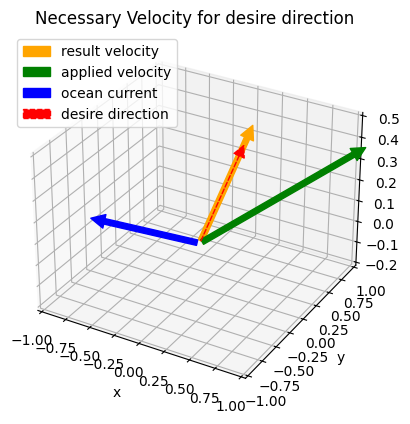

In [4]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)

    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)


# For seamless integration we add the arrow3D method to the Axes3D class.
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    """Add an 3d arrow to an `Axes3D` instance."""

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, "arrow3D", _arrow3D)


fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
lim = 1
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim / 5, lim / 2)
ax.arrow3D(
    *[0, 0, 0],
    *result_velocity,
    mutation_scale=20,
    color="orange",
    label="result velocity",
)
ax.arrow3D(
    *[0, 0, 0],
    *applied_velocity,
    mutation_scale=20,
    color="green",
    label="applied velocity",
)
ax.arrow3D(
    *[0, 0, 0],
    *ocean_current,
    mutation_scale=20,
    color="blue",
    label="ocean current",
)
ax.arrow3D(
    *[0, 0, 0],
    *desire_direction_unit_vec,
    mutation_scale=20,
    arrowstyle="-|>",
    color="red",
    linestyle="dashed",
    label="desire direction",
)

ax.set_title("Necessary Velocity for desire direction")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.show()